# LBM Step 3: Segmentation

## Segmentation: Extract neuronal locations and planar time-traces.

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

# Caiman docs on component eval

https://caiman.readthedocs.io/en/latest/Getting_Started.html#component-evaluation

> The quality of detected components is evaluated with three parameters:
>
> Spatial footprint consistency (rval): The spatial footprint of the component is compared with the frames where this component is active. Other component’s signals are subtracted from these frames, and the resulting raw data is correlated against the spatial component. This ensures that the raw data at the spatial footprint aligns with the extracted trace.
>
> Trace signal-noise-ratio (SNR): Peak SNR is calculated from strong calcium transients and the noise estimate.
>
> CNN-based classifier (cnn): The shape of components is evaluated by a 4-layered convolutional neural network trained on a manually annotated dataset. The CNN assigns a value of 0-1 to each component depending on its resemblance to a neuronal soma.
> 
> Each parameter has a low threshold:
> - (rval_lowest (default -1), SNR_lowest (default 0.5), cnn_lowest (default 0.1))
>
> and high threshold
> 
> - (rval_thr (default 0.8), min_SNR (default 2.5), min_cnn_thr (default 0.9))
> 
> A component has to exceed ALL low thresholds as well as ONE high threshold to be accepted.

In [10]:
import os

import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
from caiman.source_extraction.cnmf import cnmf, params

# os.environ['WGPU_BACKEND_TYPE']='OpenGL'
# os.environ["CONDA_PREFIX_1"] = ""
os.environ["QT_PLATFORM_PLUGIN"] = "xcb"

import logging
import pprint

#import napari

from pathlib import Path
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import zarr


try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

raw_data_path = Path().home() / "caiman_data_org"
movie_path = raw_data_path / 'animal_01' / "session_01" / 'plane_1'

pd.options.display.max_colwidth = 120

In [11]:
# set up logging
debug = True

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

if debug:
   logging.getLogger("caiman").setLevel(logging.DEBUG)

In [12]:
movie = zarr.open(movie_path)
movie.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,0
No. arrays,0
No. groups,0


# Paths (TODO)

```
/ raw_data_path/
    └── session_01
        ├── animal_01
        │   ├── pre_processed/
        │   │   ├── plane_1/
        │   │   ├── plane_1/
        │   │   ├── plane_2/
        │   │   └── plane_N/
        │   └── batch_dataframe.pickle
```

**For this demo set the `caiman_data` dir as the parent raw data path**

### Batch path, this is where caiman outputs will be organized, same as the previous step

This can be anywhere, it does not need to be under the parent raw data path.

In [13]:
batch_path = raw_data_path / 'batch.pickle'
mc.set_parent_raw_data_path(str(raw_data_path))

# you could alos load the registration batch and 
# save this patch in a new dataframe (saved to disk automatically)
try:
    df = mc.load_batch(batch_path)
except (IsADirectoryError, FileNotFoundError):
    df = mc.create_batch(batch_path)

df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2/5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2_mean_projection....,2024-09-09T14:50:33,2024-09-10T09:55:53,42.42 sec,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 'aab79e23-ebcc-45cb-a12b-6f7e3eae935c/aab79e23-ebcc-45cb-a12b-6f7e3eae935c_mean_projection....,2024-09-09T14:50:49,2024-09-10T09:57:13,42.87 sec,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
3,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T10:46:06,None,None,None,00dc740c-7cf4-4cbb-b239-4cd8fc0439a2


# CNMF

Perform CNMF using the mcorr output.

Similar to mcorr, put the CNMF params within the `main` key. The `refit` key will perform a second iteration, as shown in the `caiman` `demo_pipeline.ipynb` notebook.

## Initial parameters
In general in Caiman, estimators are first initialized with a set of parameters, and then they are fit against actual data in a separate step. In this section, we'll define a `parameters` object that will subsequently be used to initialize our different estimators. 

The parameters are divided into different categories. We will not discuss them in detail in this section, but will go over them when needed (and note that in this notebook we will mostly focus on CNMF and later steps):

- fnames: List of paths to the file(s) to be analysed. Memmap and hdf5 result files will be saved in the same directory.
- fr: Imaging frame rate in frames per second.
- decay_time: Length of a typical transient in seconds. decay_time is an approximation of the time scale over which to expect a significant shift in the calcium signal during a transient. It defaults to 0.4, which is appropriate for fast indicators (GCaMP6f), slow indicators might use 1 or even more. However, decay_time does not have to precisely fit the data, approximations are enough.
- p: Order of the autoregressive model. p = 0 turns deconvolution off. If transients in your data rise instantaneously, set p = 1 (occurs at low sample rate or slow indicator). If transients have visible rise time, set p = 2. If the wrong order is chosen, spikes are extracted unreliably.
- nb: Number of global background components. This is a measure of the complexity of your background noise. Defaults to nb = 2, assuming a relatively homogeneous background. nb = 3 might fit for more complex noise, nb = 1 is usually too low. If nb is set too low, extracted traces appear too noisy, if nb is set too high, neuronal signal starts getting absorbed into the background reduction, resulting in reduced transients.
- merge_thr: Merging threshold of components after initialization. If two components are correlated more than this value (e.g. when during initialization a neuron was split in two components), they are merged and treated as one.
- rf: Half-size of the patches in pixels. Should be at least 3 to 4 times larger than the expected neuron size to capture the complete neuron and its local background. Larger patches lead to less parallelization.
- stride: Overlap between patches in pixels. This should be roughly the neuron diameter. Larger overlap increases computational load, but yields better results during reconstruction/denoising of the data.
- K : Number of (expected) components per patch. Adapt to rf and estimated component density.
- gSig: Expected half-size of neurons in pixels [rows X columns]. CRUCIAL parameter for proper component detection.
- method_init: Initialization method, depends mainly on the recording method. Use greedy_roi for 2p data, corr_pnr for 1p data, and sparse_nmf for dendritic/axonal data.
- ssub/tsub: Spatial and temporal subsampling during initialization. Defaults to 1 (no compression). Can be set to 2 or even higher to save resources, but might impair detection/extraction quality.

In [14]:
# general dataset-dependent parameters
fr = 9.62                   # imaging rate in frames per second
decay_time = 0.4            # length of a typical transient in seconds
dxy = (1., 1.)              # spatial resolution in x and y in (um per pixel)

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between patches (width of patch = strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# CNMF parameters for source extraction and deconvolution
p = 2                       # order of the autoregressive system (set p=2 if there is visible rise time in data)
gnb = 1                     # number of global background components (set to 1 or 2)
merge_thr = 0.80            # merging threshold, max correlation allowed
bas_nonneg = True           # enforce nonnegativity constraint on calcium traces (technically on baseline)
rf = 40                     # half-size of the patches in pixels (patch width is rf*2 + 1)
stride_cnmf = 10            # amount of overlap between the patches in pixels (overlap is stride_cnmf+1) 
# K = 780                       # number of components per patch
gSig = np.array([6, 6])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation)
gSiz = None #2*gSig + 1     # Gaussian kernel width and hight
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data see demo_dendritic.ipynb)
ssub = 1                    # spatial subsampling during initialization 
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.80             # space correlation threshold for accepting a component

In [16]:
params_cnmf = {
    'main': {
        'fnames': [movie_path],
        'var_name_hdf5': 'plane_2',
        'fr': fr,
        'dxy': dxy,
        'decay_time': decay_time,
        'strides': strides,
        'overlaps': overlaps,
        'max_shifts': max_shifts,
        'max_deviation_rigid': max_deviation_rigid,
        'pw_rigid': pw_rigid,
        'p': p,
        'nb': gnb,
        'rf': rf,
        # 'K': K, 
        'gSig': gSig,
        'gSiz': gSiz,
        'stride': stride_cnmf,
        'method_init': method_init,
        'rolling_sum': True,
        'only_init': True,
        'use_cnn': False,
        'ssub': ssub,
        'tsub': tsub,
        'merge_thr': merge_thr, 
        'bas_nonneg': bas_nonneg,
        'min_SNR': min_SNR,
        'rval_thr': rval_thr,
    },
    'refit': True
}

# Run CNMF

The API is identical to running mcorr.

You can provide the mcorr item row to `input_movie_path` and it will resolve the path of the input movie from the entry in the DataFrame.

In [9]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2/5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2_mean_projection....,2024-09-09T14:50:33,2024-09-10T09:55:53,42.42 sec,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 'aab79e23-ebcc-45cb-a12b-6f7e3eae935c/aab79e23-ebcc-45cb-a12b-6f7e3eae935c_mean_projection....,2024-09-09T14:50:49,2024-09-10T09:57:13,42.87 sec,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
3,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T10:46:06,None,None,None,00dc740c-7cf4-4cbb-b239-4cd8fc0439a2


In [17]:
item1 = df.iloc[0]
item1.outputs['traceback']

'Traceback (most recent call last):\n  File "/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/mesmerize_core/algorithms/mcorr.py", line 66, in run_algo\n    mc.motion_correct(save_movie=True)\n  File "/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/motion_correction.py", line 234, in motion_correct\n    mi = min(mi, next(iterator).min()[()])\n                 ^^^^^^^^^^^^^^\n  File "/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/base/movies.py", line 1914, in load_iter\n    for y in load(file_name, var_name_hdf5=var_name_hdf5,\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/base/movies.py", line 1516, in load\n    raise Exception(\'Unknown file type\')\nException: Unknown file type\n'

In [12]:
run_last_item_flag = True
if run_last_item_flag:
    index = -1  # most recently added item
    df.iloc[index].caiman.run()

/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02.runfile
starting mc
mc failed, stored traceback in output



2024-09-09 16:21:40.811481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 16:21:40.811510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 16:21:40.811841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 16:21:40.814678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

# Reload dataframe

In [58]:
df = df.caiman.reload_from_disk()

df.caiman.add_item(
    algo='cnmf',
    input_movie_path=df.iloc[0],
    params=params_cnmf,
    item_name='caiman_phys',
)

In [59]:
df.iloc[-1].caiman.run()

2024-09-06 17:20:30.749621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 17:20:30.749650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 17:20:30.750016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                 caiman_phys
input_movie_path    9781250d-22cb-4ebc-9de1-ad97e101ddee/9781250d-...
params              {'main': {'fnames': (/home/mbo/caiman_data/ani...
outputs                                                          None
added_time                                        2024-09-06T17:20:27
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             46e6535a-9489-4fd6-8520-1d2f3bb9f11c
Name: 16, dtype: object
With params:{'main': {'fnames': (PosixPath('/home/mbo/caiman_data/animal_01/session_01/save_gui.zarr'),), 'var_name_hdf5': 'plane_2', 'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images


/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


# CNMF outputs

Similar to mcorr, you can use the `mesmerize-core` API to fetch the outputs.

[API reference for mesmerize-CNMF](https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html)
[API reference for caiman-CNMF](https://caiman.readthedocs.io/en/latest/Getting_Started.html#parameters)



## CNMF Object

In [9]:
cnmf_model = df.iloc[-1].cnmf.get_output()
correlation_image = df.iloc[-1].caiman.get_corr_image()

In [14]:
cnmf_model.params

CNMFParams:

data:

{'caiman_version': '1.11.0',
 'decay_time': 0.4,
 'dims': b'NoneType',
 'dxy': (1, 1),
 'fnames': None,
 'fr': 30,
 'last_commit': 'FILE-1723487462',
 'var_name_hdf5': 'mov'}

init:

{'K': 8,
 'SC_kernel': 'heat',
 'SC_nnn': 20,
 'SC_normalize': True,
 'SC_sigma': 1,
 'SC_thr': 0,
 'SC_use_NN': False,
 'alpha_snmf': 0.5,
 'center_psf': False,
 'gSig': array([6, 6]),
 'gSiz': array([13, 13]),
 'init_iter': 2,
 'kernel': None,
 'lambda_gnmf': 1,
 'maxIter': 5,
 'max_iter_snmf': 500,
 'method_init': 'greedy_roi',
 'min_corr': 0.85,
 'min_pnr': 20,
 'nIter': 5,
 'nb': 2,
 'normalize_init': True,
 'options_local_NMF': None,
 'perc_baseline_snmf': 20,
 'ring_size_factor': 1.5,
 'rolling_length': 100,
 'rolling_sum': True,
 'seed_method': 'auto',
 'sigma_smooth_snmf': (0.5, 0.5, 0.5),
 'ssub': 1,
 'ssub_B': 2,
 'tsub': 1}

merging:

{'do_merge': True, 'merge_parallel': False, 'merge_thr': 0.95}

motion:

{'border_nan': 'copy',
 'gSig_filt': None,
 'indices': array([b'slice

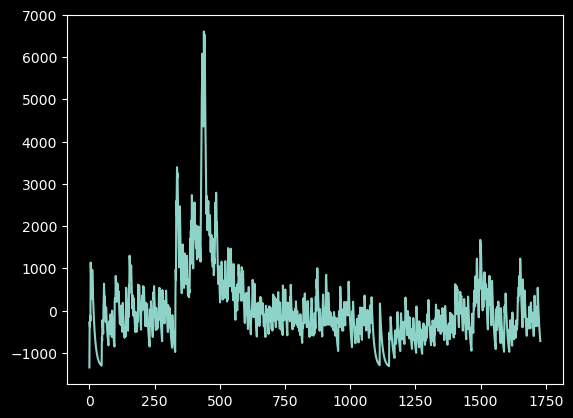

In [19]:
# dim order: txy[,z]
plt.plot(cnmf_model.estimates.C[0,:])
plt.show()

In [22]:
# calculate stride and overlap from parameters
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [9]:
index = -1  # index of the cnmf item, last item in the dataframe

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

In [10]:
temporal.shape

(4629, 1730)

Many of the cnmf functions take a rich set of arguments

In [11]:
# get accepted or rejected components
temporal_good = df.iloc[index].cnmf.get_temporal("good")

# shape is [n_components, n_frames]
temporal_good.shape

(273, 1730)

### Get specific components

In [8]:
df.iloc[-1].cnmf.get_temporal(np.array([1, 5, 9]))

array([[-1164.26197784,   482.41381104,   524.05762701, ...,
          146.58582648,  -103.30837119,  -305.56385525],
       [ -976.41859592,  1333.52341395,   895.44232658, ...,
           40.63645868,  -152.24833724,  -308.55249443],
       [ -291.12191069,   811.46900584,   886.63938853, ...,
         -177.02657974,  -193.8651116 ,  -208.21858463]])

### add risiduals / contours

In [29]:
# get temporal with the residuals, i.e. C + YrA
temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

In [30]:
# get contours
contours = df.iloc[index].cnmf.get_contours()

Returns: `(list of np.ndarray of contour coordinates, list of center of mass)`

In [31]:
print(f"contour 0 coordinates:\n\n{contours[0][0]}\n\n com: {contours[1][0]}")

contour 0 coordinates:

[[20.         25.01558346]
 [19.         25.60646128]
 [18.         25.2845259 ]
 [17.5524056  25.        ]
 [17.         24.57330747]
 [16.         24.46959915]
 [15.59287146 25.        ]
 [15.         25.62280392]
 [14.         25.49757361]
 [13.         25.22684176]
 [12.6570361  25.        ]
 [12.         24.48841853]
 [11.45336193 24.        ]
 [11.         23.66266051]
 [10.         23.51538548]
 [ 9.19089959 23.        ]
 [ 9.         22.78334966]
 [ 8.73803854 22.        ]
 [ 8.11875789 21.        ]
 [ 8.         20.59387852]
 [ 7.6882345  20.        ]
 [ 7.16678103 19.        ]
 [ 7.1318453  18.        ]
 [ 7.08960039 17.        ]
 [ 7.         16.5785856 ]
 [ 6.65247425 16.        ]
 [ 6.50517672 15.        ]
 [ 6.40926157 14.        ]
 [ 6.28386307 13.        ]
 [ 6.55689294 12.        ]
 [ 7.         11.52766769]
 [ 7.5171354  11.        ]
 [ 8.         10.51930536]
 [ 8.54780523 11.        ]
 [ 9.         11.36939161]
 [10.         11.35715476]
 [11

In [1]:
len(contours)

NameError: name 'contours' is not defined

In [33]:
# get_contours() also takes arguments
contours_good = df.iloc[index].cnmf.get_contours("good")

In [34]:
len(contours_good[0]) # number of contours

161

swap_dim

In [12]:
# get the first contour using swap_dim=True (default)
swap_dim_true = df.iloc[index].cnmf.get_contours()[0][0]

In [13]:
# get the first contour  with swap_dim=False
swap_dim_false = df.iloc[index].cnmf.get_contours(swap_dim=False)[0][0]

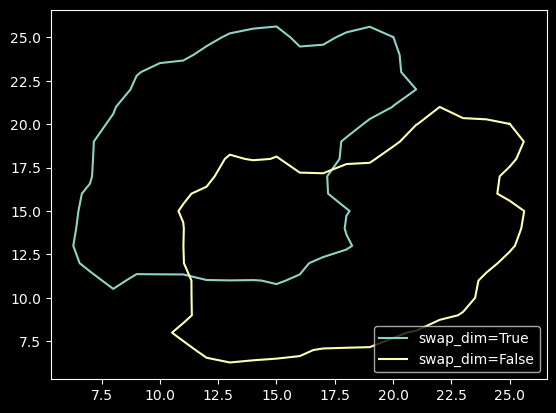

In [37]:
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    label="swap_dim=True"
)
plt.plot(
    swap_dim_false[:, 0], 
    swap_dim_false[:, 1], 
    label="swap_dim=False"
)
plt.legend()

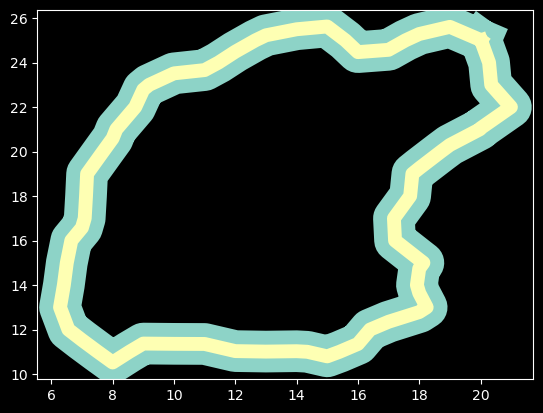

In [38]:
# swap_dim swaps the x and y dims
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    linewidth=30
)
plt.plot(
    swap_dim_false[:, 1], 
    swap_dim_false[:, 0], 
    linewidth=10
)

# Reconstructed movie - `A * C`
# Reconstructed background - `b * f`
# Residuals - `Y - AC - bf` 

Mesmerize-core provides these outputs as lazy arrays. This allows you to work with arrays that would otherwise be hundreds of gigabytes or terabytes in size.

In [14]:
rcm = df.iloc[index].cnmf.get_rcm()
rcm

LazyArrayRCM @0x7f5373a07910
LazyArray for reconstructed movie, i.e. A ⊗ C
Frames are computed only upon indexing
shape [frames, x, y]: (1730, 600, 560)
n_components: 4629

LazyArrays behave like numpy arrays

In [15]:
rcm[42]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -3.802735  ,  6.63209673, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  6.89688434,  8.99901868, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.30221454, -0.41923418, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.3223725 , -0.41923418, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
rcm[10:20].shape

(10, 600, 560)

# Using LazyArrays

In [42]:
rcm_accepted = df.iloc[index].cnmf.get_rcm("good")
rcm_rejected = df.iloc[index].cnmf.get_rcm("bad")

# All CNMF LazyArrays

In [17]:
rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

In [22]:
rcb.shape

(1730, 600, 560)

In [23]:
napari.view_image(rcb)

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'rcb' at 0x7f53578a7f50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f53560702

: 

# Parameter Gridsearch

As shown for motion correction, the purpose of `mesmerize-core` is to perform parameter searches

In [46]:
# itertools.product makes it easy to loop through parameter variants
# basically, it's easier to read that deeply nested for loops
from copy import deepcopy
from itertools import product

# variants of several parameters
gSig_variants = [4, 6]
K_variants = [4, 8]
merge_thr_variants = [0.8, 0.95]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmf",
        item_name=df.iloc[good_mcorr_index]["item_name"],  # good mcorr item
        input_movie_path=df.iloc[good_mcorr_index],
        params=new_params_cnmf
    )

We now have lot of cnmf items

In [ ]:
df

View the diffs

In [9]:
df.caiman.get_params_diffs(algo="cnmf", item_name=df.iloc[-1]["item_name"])

,merge_thr,K,gSig
4,0.85,4,"(4, 4)"
5,0.8,4,"(4, 4)"
6,0.95,4,"(4, 4)"
7,0.8,8,"(4, 4)"
8,0.95,8,"(4, 4)"
9,0.8,4,"(6, 6)"
10,0.95,4,"(6, 6)"
11,0.8,8,"(6, 6)"
12,0.95,8,"(6, 6)"


# Run the `cnmf` batch items

In [49]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

2024-09-06 02:55:39.193366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:55:39.193397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:55:39.193775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             796af0f5-678c-4a73-9991-d8d462e9d66a
Name: 5, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 02:57:23.219120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:57:23.219154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:57:23.219536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             e58bb527-8bd1-4652-82dd-bca82327a018
Name: 6, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 02:59:09.123700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:59:09.123733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:59:09.124122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             4ae126bc-4bb1-4277-946d-dbe472fde572
Name: 7, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:01:50.415064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:01:50.415100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:01:50.415485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             cf20ff30-e1cb-45ff-912a-c99b4a5939a3
Name: 8, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:04:39.929497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:04:39.929529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:04:39.929936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             72001e65-2c76-4271-bbd6-72b95ec8673e
Name: 9, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:06:34.969998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:06:34.970033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:06:34.970431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             c960003a-aacf-47f7-853f-995538f72a4d
Name: 10, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:08:30.864889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:08:30.864924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:08:30.865327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             0faa6a15-f3ee-4c34-b8cd-ce183161006a
Name: 11, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:11:37.623624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:11:37.623657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:11:37.624016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             7d6c0c06-3222-4b26-be5c-578b66e2e532
Name: 12, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


# Load outputs

In [1]:
df = df.caiman.reload_from_disk()
df

NameError: name 'df' is not defined